In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
import h5py as hdf
import scipy as scp

plt.rcParams['figure.facecolor'] = 'white'

In [9]:
positions=pd.read_excel('Y:\\Istra Repositories\\ch-gr_exports\\Querzug_overview.xlsx')
positions.name=positions.name+'_clipped_cut_lined'
positions=positions.iloc[:,1:].set_index('name')
display(positions)

,ok,crack,pos,left_12-5,step_start,step_stop
name,,,,,,
MC_A_6xi_clipped_cut_lined,1.0,135.0,143.0,123.0,110.0,230.0
MC_A_6xiii_clipped_cut_lined,1.0,115.0,119.0,99.0,45.0,187.5
MC_A_6yi_clipped_cut_lined,2.0,114.0,117.0,97.0,NaN,NaN
MC_A_6yii_clipped_cut_lined,2.0,47.0,50.0,30.0,NaN,NaN
MC_A_6yiii_clipped_cut_lined,2.0,100.0,95.0,75.0,NaN,NaN
...,...,...,...,...,...,...
QL_GW_8xi_clipped_cut_lined,3.0,NaN,NaN,-20.0,40.0,387.5
QL_GW_8xii_clipped_cut_lined,1.0,125.0,125.0,105.0,247.5,580.0
QL_GW_8xiii_clipped_cut_lined,3.0,NaN,NaN,-20.0,NaN,NaN


In [10]:
import os
import re

def gather_files_regex(dir: str,regex)->list:
    '''
    Gathers all files below a directory that match the provided regular expression
    Traverses into sub-directories

    dir -- the directory

    regex -- A regular expression to match filenames
    '''
    subdir=dir
    p = re.compile(regex)
    data=[]
    for dir, _, files in os.walk(subdir):
        for name in files:
            if p.match(name):
                b=(str(os.path.join(dir, name)))
                data.append(b)
    return data

files=gather_files_regex('Y:\\Istra Repositories\\ch-gr_exports',r'\w+ned.pickle\Z')
display(files)

['Y:\\Istra Repositories\\ch-gr_exports\\MC_A_6xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_6xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_6xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_6xii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_6xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_8xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_8xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_8yi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6yiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6yii_clipped_

In [11]:
sample='MC_A_8xiii_clipped_cut'
samplelocation='Y:\\Istra Repositories\\ch-gr_exports\\'+sample+'.pickle'
lookup=pd.read_pickle(samplelocation,compression='zip')

In [38]:
over_df_index=[x.split('\\')[-1].split('.')[0] for x in files]
tests_df=pd.DataFrame(index=over_df_index)
tests_df['paths']=files
tests_df=tests_df.join(positions,how='left')
tests_df['index']=tests_df.index
tests_df['material']=tests_df['index'].apply(lambda x: x.split('_')[0])
tests_df['senergie/GW']=tests_df['index'].apply(lambda x: x.split('_')[1])
tests_df['plate_thickness']=tests_df['index'].apply(lambda x: x.split('_')[2][0])
tests_df['testspeed']=tests_df['index'].apply(lambda x: x.split('_')[2][1])
tests_df['running_number']=tests_df['index'].apply(lambda x: x.split('_')[2][2:])
tests_df['data']=[pd.read_pickle(x, compression='zip') for x in tests_df['paths']]
display(tests_df.head(5))
#plt.plot(tests_df.crack)

,paths,ok,crack,pos,left_12-5,step_start,step_stop,index,material,senergie/GW,plate_thickness,testspeed,running_number,data
MC_A_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii...,1.0,115.0,119.0,99.0,45.0,187.5,MC_A_6xiii_clipped_cut_lined,MC,A,6,x,iii,group ...
MC_A_6xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xi_c...,1.0,135.0,143.0,123.0,110.0,230.0,MC_A_6xi_clipped_cut_lined,MC,A,6,x,i,group ...
MC_A_8xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_8xiii...,1.0,170.0,117.5,97.5,32.5,355.0,MC_A_8xiii_clipped_cut_lined,MC,A,8,x,iii,group ...
MC_B_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xiii...,1.0,90.0,90.0,70.0,37.5,172.5,MC_B_6xiii_clipped_cut_lined,MC,B,6,x,iii,group ...
MC_B_6xii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xii_...,1.0,122.0,121.0,101.0,27.5,160.0,MC_B_6xii_clipped_cut_lined,MC,B,6,x,ii,group ...


In [39]:
#display(test.data)

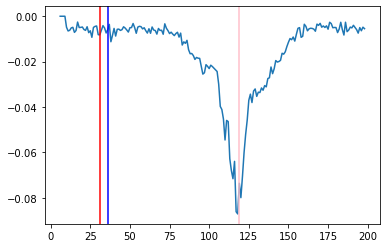

In [40]:
test=tests_df.data[0]
sample=tests_df['index'][0]
def array_get_mask(array:np.ndarray)->pd.DataFrame:
    df=pd.DataFrame(array)
    after=df.copy()
    after[after==0.]=np.nan
    after=np.divide(after,after)
    return(after)
#mask=array_get_mask(test.iloc[10,:][('strains','strain_p1')])
#plt.matshow(mask)
def df_apply_mask(arr:np.ndarray,mask:np.ndarray)-> pd.DataFrame:
    after=np.multiply(arr,mask)
    after=pd.DataFrame(after)
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)
#plt.matshow(df_apply_mask(array_get_mask(test.iloc[10,:][('strains','strain_p1')]),mask))
def df_strip_nans(df):
    after=df.copy()
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)
def df_get_idx_from_mm(sample:str,data:pd.DataFrame,sdix,cdix,left:int,right:int):
    mask=array_get_mask(data.iloc[10,:][('strains','strain_p1')])
    horizontal_measured_mm=data.iloc[10,:][('coordinates','coordinate_y')]
    measurement_dict=horizontal_measured_mm.to_dict()
    measurement_lookup_df=pd.DataFrame(data=measurement_dict.values(), index=measurement_dict.keys(),columns=['mm'])
    #display(measurement_lookup_df)
    crack_idx=int(cdix)
    seam_idx=int(sdix)

    seam_pos_y_mm=measurement_lookup_df.loc[seam_idx,'mm']
    left_pos_y_mm=seam_pos_y_mm-left
    right_pos_y_mm=seam_pos_y_mm-right

    left_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-left_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]
    right_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-right_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]

    """fig,ax=plt.subplots(figsize=(20,5))
    ax.matshow(df_apply_mask(data.iloc[150,:][('strains','strain_p1')],mask))
    ax.axvline(left_pos_y_idx,c='red')
    ax.axvline(right_pos_y_idx,c='yellow')
    plt.show()"""
    return(seam_idx,left_pos_y_idx,right_pos_y_idx)
def df_extract_roi_on_idx(roi_base,left,right):
    roi_base=pd.DataFrame(roi_base).copy()

    roi_base.loc[:,:left]=np.nan
    roi_base.loc[:,right:]=np.nan
    return(roi_base)
#df_get_idx_from_mm(sample,lookup,positions,-20,-18)
borders=df_get_idx_from_mm(sample,test,119.0,115.0,-35,-33)
fig,ax=plt.subplots()
ax.plot(tests_df.data[0].iloc[-10,6])#.loc[borders[1]:borders[2]])
ax.axvline(borders[1],color='red')
ax.axvline(borders[2],color='blue')
ax.axvline(borders[0],color='pink')
plt.show()
#plt.matshow(df_strip_nans(df_extract_roi_on_idx(df_apply_mask(array_get_mask(test.iloc[130,:][('strains','strain_p1')]),mask),borders[1],borders[2])))

In [41]:
display(test.iloc[0,3])



6     -23.113460
7     -23.174919
8     -23.230551
9     -23.275849
10    -23.328638
         ...    
194   -15.198407
195   -15.143376
196   -15.103652
197   -15.046472
198   -15.002882
Length: 193, dtype: float64

,paths,ok,crack,pos,left_12-5,step_start,step_stop,index,material,senergie/GW,...,15_17 _idxs,17_19 _idxs,19_21 _idxs,21_23 _idxs,23_25 _idxs,25_27 _idxs,27_29 _idxs,29_31 _idxs,31_33 _idxs,33_35 _idxs
MC_A_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii...,1.0,115.0,119.0,99.0,45.0,187.5,MC_A_6xiii_clipped_cut_lined,MC,A,...,"(119, 157, 162)","(119, 162, 167)","(119, 167, 172)","(119, 172, 177)","(119, 177, 182)","(119, 182, 187)","(119, 187, 192)","(119, 192, 197)","(119, 197, 198)","(119, 198, 198)"
MC_A_6xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xi_c...,1.0,135.0,143.0,123.0,110.0,230.0,MC_A_6xi_clipped_cut_lined,MC,A,...,"(143, 180, 185)","(143, 185, 190)","(143, 190, 195)","(143, 195, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)"
MC_A_8xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_8xiii...,1.0,170.0,117.5,97.5,32.5,355.0,MC_A_8xiii_clipped_cut_lined,MC,A,...,"(117, 154, 159)","(117, 159, 163)","(117, 163, 168)","(117, 168, 173)","(117, 173, 178)","(117, 178, 183)","(117, 183, 188)","(117, 188, 193)","(117, 193, 198)","(117, 198, 201)"
MC_B_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xiii...,1.0,90.0,90.0,70.0,37.5,172.5,MC_B_6xiii_clipped_cut_lined,MC,B,...,"(90, 126, 131)","(90, 131, 136)","(90, 136, 141)","(90, 141, 146)","(90, 146, 151)","(90, 151, 156)","(90, 156, 161)","(90, 161, 165)","(90, 165, 170)","(90, 170, 175)"
MC_B_6xii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xii_...,1.0,122.0,121.0,101.0,27.5,160.0,MC_B_6xii_clipped_cut_lined,MC,B,...,"(121, 159, 164)","(121, 164, 169)","(121, 169, 174)","(121, 174, 179)","(121, 179, 184)","(121, 184, 189)","(121, 189, 194)","(121, 194, 199)","(121, 199, 201)","(121, 201, 201)"


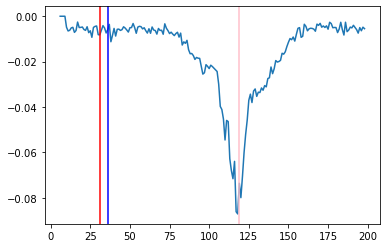

In [42]:
def idx_runner(tests_df):
    tests_df['-35_-33_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-35,-33))
    tests_df['-33_-31_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-33,-31))
    tests_df['-31_-29_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-31,-29))
    tests_df['-29_-27_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-29,-27))
    tests_df['-27_-25_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-27,-25))
    tests_df['-25_-23_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-25,-23))
    tests_df['-23_-21_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-23,-21))
    tests_df['-21_-19_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-21,-19))
    tests_df['-19_-17_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-19,-17))
    tests_df['-17_-15_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-17,-15))
    tests_df['-15_-13_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-15,-13))
    tests_df['-13_-11_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-13,-11))
    tests_df['-11_-9 _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-11,-9))
    tests_df['-9_-7  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-9,-7))
    tests_df['-7_-5  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-7,-5))
    tests_df['-5_-3  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-5,-3))
    tests_df['-3_-1  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-3,-1))
    tests_df['-1_1   _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-1,1))
    tests_df['1_3    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],1,3))
    tests_df['3_5    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],3,5))
    tests_df['5_7    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],5,7))
    tests_df['7_9    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],7,9))
    tests_df['9_11   _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],9,11))
    tests_df['11_13  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],11,13))
    tests_df['13_15  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],13,15))
    tests_df['15_17  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],15,17))
    tests_df['17_19  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],17,19))
    tests_df['19_21  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],19,21))
    tests_df['21_23  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],21,23))
    tests_df['23_25  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],23,25))
    tests_df['25_27  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],25,27))
    tests_df['27_29  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],27,29))
    tests_df['29_31  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],29,31))
    tests_df['31_33  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],31,33))
    tests_df['33_35  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],33,35))
    return (tests_df)
tests_df=idx_runner(tests_df)
display(tests_df.head())

fig,ax=plt.subplots()
ax.plot(tests_df.data[0].iloc[-10,6])
ax.axvline(tests_df['-35_-33_idxs'][0][1],color='red')
ax.axvline(tests_df['-35_-33_idxs'][0][2],color='blue')
ax.axvline(tests_df['-35_-33_idxs'][0][0],color='pink')
plt.show()
test=tests_df

Index(['paths', 'ok', 'crack', 'pos', 'left_12-5', 'step_start', 'step_stop',
       'index', 'material', 'senergie/GW', 'plate_thickness', 'testspeed',
       'running_number', 'data', '-35_-33_idxs', '-33_-31_idxs',
       '-31_-29_idxs', '-29_-27_idxs', '-27_-25_idxs', '-25_-23_idxs',
       '-23_-21_idxs', '-21_-19_idxs', '-19_-17_idxs', '-17_-15_idxs',
       '-15_-13_idxs', '-13_-11_idxs', '-11_-9 _idxs', '-9_-7  _idxs',
       '-7_-5  _idxs', '-5_-3  _idxs', '-3_-1  _idxs', '-1_1   _idxs',
       '1_3    _idxs', '3_5    _idxs', '5_7    _idxs', '7_9    _idxs',
       '9_11   _idxs', '11_13  _idxs', '13_15  _idxs', '15_17  _idxs',
       '17_19  _idxs', '19_21  _idxs', '21_23  _idxs', '23_25  _idxs',
       '25_27  _idxs', '27_29  _idxs', '29_31  _idxs', '31_33  _idxs',
       '33_35  _idxs'],
      dtype='object')

(142, 10)

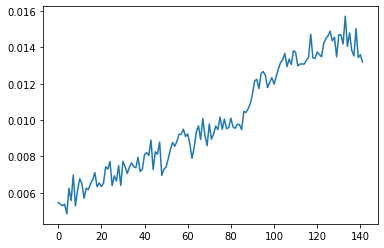

In [46]:

def df_loc_strain(df,left,right):
    strain_p1=[]
    for i in df.index:
        strain_p1.append(df.loc[i,(      'strains',          'strain_p1')].loc[left:right].mean())
    #display(strain_p1)
    #plt.plot(strain_p1)
    return(strain_p1)

display(tests_df.columns)
plt.plot(df_loc_strain(tests_df.data[0],tests_df['15_17  _idxs'][0][1],tests_df['15_17  _idxs'][0][2]))
display(tests_df.data[0].shape)

Index(['paths', 'ok', 'crack', 'pos', 'left_12-5', 'step_start', 'step_stop',
       'index', 'material', 'senergie/GW', 'plate_thickness', 'testspeed',
       'running_number', 'data', '-35_-33_idxs', '-33_-31_idxs',
       '-31_-29_idxs', '-29_-27_idxs', '-27_-25_idxs', '-25_-23_idxs',
       '-23_-21_idxs', '-21_-19_idxs', '-19_-17_idxs', '-17_-15_idxs',
       '-15_-13_idxs', '-13_-11_idxs', '-11_-9 _idxs', '-9_-7  _idxs',
       '-7_-5  _idxs', '-5_-3  _idxs', '-3_-1  _idxs', '-1_1   _idxs',
       '1_3    _idxs', '3_5    _idxs', '5_7    _idxs', '7_9    _idxs',
       '9_11   _idxs', '11_13  _idxs', '13_15  _idxs', '15_17  _idxs',
       '17_19  _idxs', '19_21  _idxs', '21_23  _idxs', '23_25  _idxs',
       '25_27  _idxs', '27_29  _idxs', '29_31  _idxs', '31_33  _idxs',
       '33_35  _idxs', '-35_-33_strain_p1', '-33_-31_strain_p1',
       '-31_-29_strain_p1', '-29_-27_strain_p1', '-27_-25_strain_p1',
       '-25_-23_strain_p1', '-23_-21_strain_p1', '-21_-19_strain_p1',
       '-

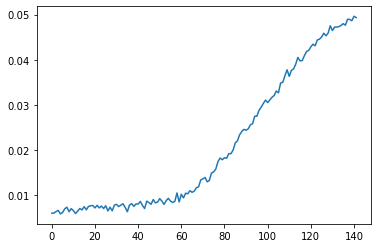

In [48]:
tests_df['-35_-33_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-35_-33_idxs'][1],tests_df.loc[i,'-35_-33_idxs'][2]) for i in tests_df.index]
tests_df['-33_-31_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-33_-31_idxs'][1],tests_df.loc[i,'-33_-31_idxs'][2]) for i in tests_df.index]
tests_df['-31_-29_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-31_-29_idxs'][1],tests_df.loc[i,'-31_-29_idxs'][2]) for i in tests_df.index]
tests_df['-29_-27_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-29_-27_idxs'][1],tests_df.loc[i,'-29_-27_idxs'][2]) for i in tests_df.index]
tests_df['-27_-25_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-27_-25_idxs'][1],tests_df.loc[i,'-27_-25_idxs'][2]) for i in tests_df.index]
tests_df['-25_-23_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-25_-23_idxs'][1],tests_df.loc[i,'-25_-23_idxs'][2]) for i in tests_df.index]
tests_df['-23_-21_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-23_-21_idxs'][1],tests_df.loc[i,'-23_-21_idxs'][2]) for i in tests_df.index]
tests_df['-21_-19_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-21_-19_idxs'][1],tests_df.loc[i,'-21_-19_idxs'][2]) for i in tests_df.index]
tests_df['-19_-17_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-19_-17_idxs'][1],tests_df.loc[i,'-19_-17_idxs'][2]) for i in tests_df.index]
tests_df['-17_-15_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-17_-15_idxs'][1],tests_df.loc[i,'-17_-15_idxs'][2]) for i in tests_df.index]
tests_df['-15_-13_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-15_-13_idxs'][1],tests_df.loc[i,'-15_-13_idxs'][2]) for i in tests_df.index]
tests_df['-13_-11_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-13_-11_idxs'][1],tests_df.loc[i,'-13_-11_idxs'][2]) for i in tests_df.index]
tests_df['-11_-9 _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-11_-9 _idxs'][1],tests_df.loc[i,'-11_-9 _idxs'][2]) for i in tests_df.index]
tests_df['-9_-7  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-9_-7  _idxs'][1],tests_df.loc[i,'-9_-7  _idxs'][2]) for i in tests_df.index]
tests_df['-7_-5  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-7_-5  _idxs'][1],tests_df.loc[i,'-7_-5  _idxs'][2]) for i in tests_df.index]
tests_df['-5_-3  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-5_-3  _idxs'][1],tests_df.loc[i,'-5_-3  _idxs'][2]) for i in tests_df.index]
tests_df['-3_-1  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-3_-1  _idxs'][1],tests_df.loc[i,'-3_-1  _idxs'][2]) for i in tests_df.index]
tests_df['-1_1   _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-1_1   _idxs'][1],tests_df.loc[i,'-1_1   _idxs'][2]) for i in tests_df.index]
tests_df['1_3    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'1_3    _idxs'][1],tests_df.loc[i,'1_3    _idxs'][2]) for i in tests_df.index]
tests_df['3_5    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'3_5    _idxs'][1],tests_df.loc[i,'3_5    _idxs'][2]) for i in tests_df.index]
tests_df['5_7    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'5_7    _idxs'][1],tests_df.loc[i,'5_7    _idxs'][2]) for i in tests_df.index]
tests_df['7_9    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'7_9    _idxs'][1],tests_df.loc[i,'7_9    _idxs'][2]) for i in tests_df.index]
tests_df['9_11   _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'9_11   _idxs'][1],tests_df.loc[i,'9_11   _idxs'][2]) for i in tests_df.index]
tests_df['11_13  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'11_13  _idxs'][1],tests_df.loc[i,'11_13  _idxs'][2]) for i in tests_df.index]
tests_df['13_15  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'13_15  _idxs'][1],tests_df.loc[i,'13_15  _idxs'][2]) for i in tests_df.index]
tests_df['15_17  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'15_17  _idxs'][1],tests_df.loc[i,'15_17  _idxs'][2]) for i in tests_df.index]
tests_df['17_19  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'17_19  _idxs'][1],tests_df.loc[i,'17_19  _idxs'][2]) for i in tests_df.index]
tests_df['19_21  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'19_21  _idxs'][1],tests_df.loc[i,'19_21  _idxs'][2]) for i in tests_df.index]
tests_df['21_23  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'21_23  _idxs'][1],tests_df.loc[i,'21_23  _idxs'][2]) for i in tests_df.index]
tests_df['23_25  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'23_25  _idxs'][1],tests_df.loc[i,'23_25  _idxs'][2]) for i in tests_df.index]
tests_df['25_27  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'25_27  _idxs'][1],tests_df.loc[i,'25_27  _idxs'][2]) for i in tests_df.index]
tests_df['27_29  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'27_29  _idxs'][1],tests_df.loc[i,'27_29  _idxs'][2]) for i in tests_df.index]
tests_df['29_31  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'29_31  _idxs'][1],tests_df.loc[i,'29_31  _idxs'][2]) for i in tests_df.index]
tests_df['31_33  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'31_33  _idxs'][1],tests_df.loc[i,'31_33  _idxs'][2]) for i in tests_df.index]
tests_df['33_35  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'33_35  _idxs'][1],tests_df.loc[i,'33_35  _idxs'][2]) for i in tests_df.index]
display(tests_df.columns)
plt.plot(tests_df['9_11   _strain_p1'][0])


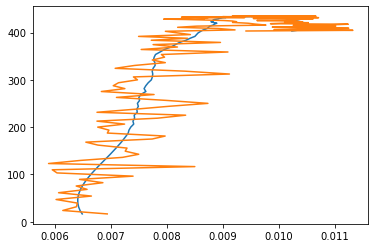

In [85]:
def force_extractor(series):
    series=series.copy()
    force=[]
    for i in series.index:
        series[i]=series[i][0][0]

    return(series)
#display(force_extractor(tests_df.loc['MC_A_6xiii_clipped_cut_lined','data'][(     'add_data',    'analog_channels')]))
tests_df['force']= [force_extractor(tests_df.loc[i,'data'][(     'add_data',    'analog_channels')]) for i in tests_df.index]
mapper={8:20,6:30}##Martin nach genauen Maßen fragen
tests_df['plate_width']=tests_df.plate_thickness.astype(int).map(mapper)
tests_df['sample_crossection']=tests_df['plate_width']*tests_df.plate_thickness.astype(int)
tests_df['stress']=[tests_df.loc[i,'force']*tests_df.loc[i,'sample_crossection'] for i in tests_df.index]
#display(tests_df.sample_crossection)
#plt.plot(tests_df.plate_width)
from scipy.signal import savgol_filter as savgol
plt.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),tests_df['stress'][0])
plt.plot(tests_df['25_27  _strain_p1'][0],tests_df['stress'][0])

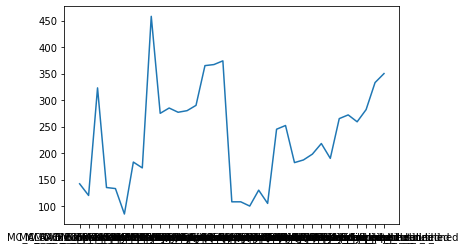

In [64]:
tests_df['data_len']=[len(tests_df.loc[i,'data']) for i in tests_df.index]
plt.plot(tests_df.data_len)

In [65]:
display(tests_df.columns)


Index(['paths', 'ok', 'crack', 'pos', 'left_12-5', 'step_start', 'step_stop',
       'index', 'material', 'senergie/GW', 'plate_thickness', 'testspeed',
       'running_number', 'data', '-35_-33_idxs', '-33_-31_idxs',
       '-31_-29_idxs', '-29_-27_idxs', '-27_-25_idxs', '-25_-23_idxs',
       '-23_-21_idxs', '-21_-19_idxs', '-19_-17_idxs', '-17_-15_idxs',
       '-15_-13_idxs', '-13_-11_idxs', '-11_-9 _idxs', '-9_-7  _idxs',
       '-7_-5  _idxs', '-5_-3  _idxs', '-3_-1  _idxs', '-1_1   _idxs',
       '1_3    _idxs', '3_5    _idxs', '5_7    _idxs', '7_9    _idxs',
       '9_11   _idxs', '11_13  _idxs', '13_15  _idxs', '15_17  _idxs',
       '17_19  _idxs', '19_21  _idxs', '21_23  _idxs', '23_25  _idxs',
       '25_27  _idxs', '27_29  _idxs', '29_31  _idxs', '31_33  _idxs',
       '33_35  _idxs', '-35_-33_strain_p1', '-33_-31_strain_p1',
       '-31_-29_strain_p1', '-29_-27_strain_p1', '-27_-25_strain_p1',
       '-25_-23_strain_p1', '-23_-21_strain_p1', '-21_-19_strain_p1',
       '-

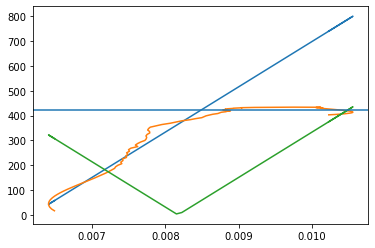

MC_A_6xiii_clipped_cut_lined      [153746.55518282222, -792.1301311227534]
MC_A_6xi_clipped_cut_lined       [177013.54189441924, -1047.8720515414077]
MC_A_8xiii_clipped_cut_lined       [70997.35227110838, -87.52239192438282]
MC_B_6xiii_clipped_cut_lined      [124993.27821541547, -526.2361563712366]
MC_B_6xii_clipped_cut_lined       [152175.56741137253, -834.8538380990693]
MC_B_6xi_clipped_cut_lined         [322515.1718159298, -2048.472575703635]
MC_B_8xiii_clipped_cut_lined      [180261.03482654397, -723.8969605410451]
MC_B_8xi_clipped_cut_lined          [168557.7755375511, -806.647908312303]
MC_B_8yi_clipped_cut_lined       [-1232.3585476494427, -15.16204924060329]
MC_GW_6xiii_clipped_cut_lined      [60955.49881767779, -446.6268939814269]
MC_GW_6xi_clipped_cut_lined       [42704.175308749465, -308.7672067173004]
MC_GW_6yiii_clipped_cut_lined      [303082.5854873459, -2406.626982453846]
MC_GW_6yii_clipped_cut_lined      [175771.4047181677, -255.96012066854288]
MC_GW_6yi_clipped_cut_lin

MC_A_6xiii_clipped_cut_lined      443.848127
MC_A_6xi_clipped_cut_lined        375.829784
MC_A_8xiii_clipped_cut_lined      639.745815
MC_B_6xiii_clipped_cut_lined      349.644201
MC_B_6xii_clipped_cut_lined       337.893691
MC_B_6xi_clipped_cut_lined        370.767535
MC_B_8xiii_clipped_cut_lined      571.631930
MC_B_8xi_clipped_cut_lined        567.415679
MC_B_8yi_clipped_cut_lined        -30.278642
MC_GW_6xiii_clipped_cut_lined     379.168794
MC_GW_6xi_clipped_cut_lined       800.087977
MC_GW_6yiii_clipped_cut_lined     600.150140
MC_GW_6yii_clipped_cut_lined     1775.532436
MC_GW_6yi_clipped_cut_lined      1799.346208
MC_GW_8xi_clipped_cut_lined       496.306811
MC_GW_8yiii_clipped_cut_lined    1631.513836
MC_GW_8yii_clipped_cut_lined     1618.419172
QL_A_6xiii_clipped_cut_lined      361.366654
QL_A_6xii_clipped_cut_lined       337.408117
QL_A_6xi_clipped_cut_lined        414.523239
QL_A_8xii_clipped_cut_lined       643.191274
QL_A_8xi_clipped_cut_lined        598.122315
QL_A_8yiii

In [169]:
def emod(start,end,stress,strain):
    #print(start,end)
    #print(type(stress),type(strain))
    strain=np.array(strain)
    strainc=strain[range(start,end)]

    stressc=np.array(stress[range(start,end)])
    #plt.plot((strainc),(stressc))
    try:
        z=np.polyfit(list(strainc), list(stressc), 1)
        p=np.poly1d(z)
        emod=z
        n=[p(x) for x in strainc]
        return(emod,n)
    except:
        return ([[180000,5]])
def rp02 (emod,stress,strain):
    df=pd.DataFrame()
    df['stress']=stress
    df['strain']=strain
    df['rpcurve']=(df.strain*emod[0]+emod[1])-(0.002*emod[0])
    idx=df.iloc[(df['stress']-df['rpcurve']).abs().argsort()[:1]].index.tolist()[0]
    #print(idx,df.loc[idx,'stress'],df.loc[idx,'rpcurve'])
    return (df.loc[idx,'rpcurve'])

def smoothing(strain):
    try:
        return(savgol(strain,51,4))
    except:
        return strain

E=emod(0,int(len(tests_df['stress'][0])*0.3),tests_df['stress'][0],savgol(tests_df['25_27  _strain_p1'][0],51,4))[0]
rp=(rp02(E,tests_df['stress'][0],savgol(tests_df['25_27  _strain_p1'][0],51,4)))
fig,ax=plt.subplots()
ax.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),
         [x*E[0]+E[1] for x in savgol(tests_df['25_27  _strain_p1'][0],51,4)]

         )
ax.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),
         tests_df['stress'][0]

         )
ax.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),
         [abs((x*E[0]+E[1])-(0.002*E[0])) for x in savgol(tests_df['25_27  _strain_p1'][0],51,4)]

         )
ax.axhline(rp)
plt.show()

#for i in test.index[:-3]:
#    print(i)
#    plt.plot(savgol(tests_df.loc[i,'-33_-31_strain_p1'],41,4))
tests_df['-35_-33_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-35_-33_strain_p1']))[0] for i in tests_df.index]
tests_df['-33_-31_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-33_-31_strain_p1']))[0] for i in tests_df.index]
tests_df['-31_-29_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-31_-29_strain_p1']))[0] for i in tests_df.index]
tests_df['-29_-27_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-29_-27_strain_p1']))[0] for i in tests_df.index]
tests_df['-27_-25_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-27_-25_strain_p1']))[0] for i in tests_df.index]
tests_df['-25_-23_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-25_-23_strain_p1']))[0] for i in tests_df.index]
tests_df['-23_-21_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-23_-21_strain_p1']))[0] for i in tests_df.index]
tests_df['-21_-19_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-21_-19_strain_p1']))[0] for i in tests_df.index]
tests_df['-19_-17_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-19_-17_strain_p1']))[0] for i in tests_df.index]
tests_df['-17_-15_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-17_-15_strain_p1']))[0] for i in tests_df.index]
tests_df['-15_-13_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-15_-13_strain_p1']))[0] for i in tests_df.index]
tests_df['-13_-11_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-13_-11_strain_p1']))[0] for i in tests_df.index]
tests_df['-11_-9 _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-11_-9 _strain_p1']))[0] for i in tests_df.index]
tests_df['-9_-7  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-9_-7  _strain_p1']))[0] for i in tests_df.index]
tests_df['-7_-5  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-7_-5  _strain_p1']))[0] for i in tests_df.index]
tests_df['-5_-3  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-5_-3  _strain_p1']))[0] for i in tests_df.index]
tests_df['-3_-1  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-3_-1  _strain_p1']))[0] for i in tests_df.index]
tests_df['-1_1   _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-1_1   _strain_p1']))[0] for i in tests_df.index]
tests_df['1_3    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'1_3    _strain_p1']))[0] for i in tests_df.index]
tests_df['3_5    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'3_5    _strain_p1']))[0] for i in tests_df.index]
tests_df['5_7    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'5_7    _strain_p1']))[0] for i in tests_df.index]
tests_df['7_9    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'7_9    _strain_p1']))[0] for i in tests_df.index]
tests_df['9_11   _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'9_11   _strain_p1']))[0] for i in tests_df.index]
tests_df['11_13  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'11_13  _strain_p1']))[0] for i in tests_df.index]
tests_df['13_15  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'13_15  _strain_p1']))[0] for i in tests_df.index]
tests_df['15_17  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'15_17  _strain_p1']))[0] for i in tests_df.index]
tests_df['17_19  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'17_19  _strain_p1']))[0] for i in tests_df.index]
tests_df['19_21  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'19_21  _strain_p1']))[0] for i in tests_df.index]
tests_df['21_23  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'21_23  _strain_p1']))[0] for i in tests_df.index]
tests_df['23_25  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'23_25  _strain_p1']))[0] for i in tests_df.index]
tests_df['25_27  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'25_27  _strain_p1']))[0] for i in tests_df.index]
tests_df['27_29  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'27_29  _strain_p1']))[0] for i in tests_df.index]
tests_df['29_31  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'29_31  _strain_p1']))[0] for i in tests_df.index]
tests_df['31_33  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'31_33  _strain_p1']))[0] for i in tests_df.index]
tests_df['33_35  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'33_35  _strain_p1']))[0] for i in tests_df.index]

display(tests_df['5_7    _Emod'])

tests_df['-35_-33_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-35_-33_strain_p1'])) for i in tests_df.index]
tests_df['-33_-31_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-33_-31_strain_p1'])) for i in tests_df.index]
tests_df['-31_-29_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-31_-29_strain_p1'])) for i in tests_df.index]
tests_df['-29_-27_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-29_-27_strain_p1'])) for i in tests_df.index]
tests_df['-27_-25_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-27_-25_strain_p1'])) for i in tests_df.index]
tests_df['-25_-23_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-25_-23_strain_p1'])) for i in tests_df.index]
tests_df['-23_-21_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-23_-21_strain_p1'])) for i in tests_df.index]
tests_df['-21_-19_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-21_-19_strain_p1'])) for i in tests_df.index]
tests_df['-19_-17_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-19_-17_strain_p1'])) for i in tests_df.index]
tests_df['-17_-15_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-17_-15_strain_p1'])) for i in tests_df.index]
tests_df['-15_-13_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-15_-13_strain_p1'])) for i in tests_df.index]
tests_df['-13_-11_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-13_-11_strain_p1'])) for i in tests_df.index]
tests_df['-11_-9 _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-11_-9 _strain_p1'])) for i in tests_df.index]
tests_df['-9_-7  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-9_-7  _strain_p1'])) for i in tests_df.index]
tests_df['-7_-5  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-7_-5  _strain_p1'])) for i in tests_df.index]
tests_df['-5_-3  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-5_-3  _strain_p1'])) for i in tests_df.index]
tests_df['-3_-1  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-3_-1  _strain_p1'])) for i in tests_df.index]
tests_df['-1_1   _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-1_1   _strain_p1'])) for i in tests_df.index]
tests_df['1_3    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'1_3    _strain_p1'])) for i in tests_df.index]
tests_df['3_5    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'3_5    _strain_p1'])) for i in tests_df.index]
tests_df['5_7    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'5_7    _strain_p1'])) for i in tests_df.index]
tests_df['7_9    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'7_9    _strain_p1'])) for i in tests_df.index]
tests_df['9_11   _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'9_11   _strain_p1'])) for i in tests_df.index]
tests_df['11_13  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'11_13  _strain_p1'])) for i in tests_df.index]
tests_df['13_15  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'13_15  _strain_p1'])) for i in tests_df.index]
tests_df['15_17  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'15_17  _strain_p1'])) for i in tests_df.index]
tests_df['17_19  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'17_19  _strain_p1'])) for i in tests_df.index]
tests_df['19_21  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'19_21  _strain_p1'])) for i in tests_df.index]
tests_df['21_23  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'21_23  _strain_p1'])) for i in tests_df.index]
tests_df['23_25  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'23_25  _strain_p1'])) for i in tests_df.index]
tests_df['25_27  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'25_27  _strain_p1'])) for i in tests_df.index]
tests_df['27_29  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'27_29  _strain_p1'])) for i in tests_df.index]
tests_df['29_31  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'29_31  _strain_p1'])) for i in tests_df.index]
tests_df['31_33  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'31_33  _strain_p1'])) for i in tests_df.index]
tests_df['33_35  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'33_35  _strain_p1'])) for i in tests_df.index]

display(tests_df['5_7    _rp02'])

#def meaner (series):
#    means=[]
#    for














In [176]:
display(list(tests_df.testspeed))

['x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'x',
 'y',
 'x',
 'x',
 'y',
 'y',
 'y',
 'x',
 'y',
 'y',
 'x',
 'x',
 'x',
 'x',
 'x',
 'y',
 'y',
 'x',
 'x',
 'x',
 'y',
 'y',
 'x',
 'x',
 'y',
 'y',
 'x',
 'y']

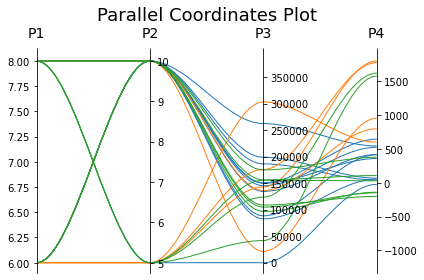

In [185]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np

fig, host = plt.subplots()

# create some dummy data
ynames = ['P1', 'P2', 'P3', 'P4']
N1, N2, N3 = 10, 5, 8
N = N1 + N2 + N3
category = np.concatenate([np.full(N1, 1), np.full(N2, 2), np.full(N3, 3)])
y1 = tests_df.plate_thickness.astype(int)
y2 = tests_df.testspeed.map({'x':10,'y':5})
y3 = [tests_df.loc[i,'31_33  _Emod'][0] for i in tests_df.index]
y4 = tests_df['31_33  _rp02']
#y5 = np.random.uniform(0, 800, N)

all=pd.DataFrame({
    'y1':y1,
    'y2':y2,
    'y3':y3,
    'y4':y4


})
all.dropna(axis=0,inplace=True)

y1=all['y1']
y2=all['y2']
y3=all['y3']
y4=all['y4']





# organize the data
ys = np.dstack([y1, y2, y3, y4])[0]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]


axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Parallel Coordinates Plot', fontsize=18)

colors = plt.cm.tab10.colors
for j in range(N):
    # to just draw straight lines between the axes:
    # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1, edgecolor=colors[category[j] - 1])
    host.add_patch(patch)
plt.tight_layout()
plt.show()